# Data Reduction 2 - ASW_C2H6

**Baseline Correction**

3 different subnotebook
- ASW
- C2H6
- **C2H6_ASW**

## Imports

In [1]:
%matplotlib inline

import numpy 
import math
from math import isnan
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.colors as mcolors
import pandas as pd
import glob
from functools import reduce
import ipywidgets as widgets
import matplotlib.gridspec as gridspec
from datetime import datetime
from IPython.core.display import SVG
import re
import json

## Input Parameters

$\color{red}{\text{Implement manually !}}$

In [2]:
# 0.1 Date
date = "2021_01_29"

# 0.2 XP
XP = "XP_1-2"

# 0.3 Sample type
spl = "C2H6_ASW"

# 0.4 Deposition Temperature
Tdep = "20"

# Colormap normalisation

# Be carefull because it may depend between the different samples

Tmin = 20
Tmax = 150


# Is there any Isotherm ?

Iso = True

# How do I deal with this now ?

## Load Data

In [3]:
# All_RAW_df

All_RAW_df = pd.read_csv("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR1_{}_All-scans.csv".format(XP,date,date))

All_RAW_df = All_RAW_df.iloc[:,1:]

# data_annex
data_annex_df = pd.read_csv("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR1_{}_data_annex.csv".format(XP,date,date))

data_annex_df = data_annex_df.iloc[:,1:]

# XP_list_test

XP_Ramp_df = pd.read_csv('..\..\DATA\DATA-Processing\PAC\XP_list_test.csv')

XP_Ramp_df_date = XP_Ramp_df.loc[XP_Ramp_df['Date'] == date]
XP_Ramp_df_date2 = XP_Ramp_df_date.set_index("Date")
#XP_Ramp_df_date2
XP_Ramp_df_T = XP_Ramp_df_date2.T
#XP_Ramp_df_T
XP_Ramp_df_T_f = XP_Ramp_df_T.iloc[1: , :]
#XP_Ramp_df_T_f
XP_Ramp_df_T_f2=XP_Ramp_df_T_f.dropna()
XP_Ramp_df_T_f2

# Produce dictionnary

Tdictionary = dict(zip(XP_Ramp_df_T_f2.index, XP_Ramp_df_T_f2[date]))

## Sanity Check

In [4]:
# All_RAW_df
data_annex_df
# XP_Ramp_df
# Tdictionary

,Name,min1,index1,min2,index2,min3,index3,min4,index4,min5,index5,min6,index6,max,max_index
0,C2H6_ASW_2021_01_29_1,-0.028472,6638,-0.017662,4239,-0.017451,4132,-0.008102,2409,-0.007515,2275,-0.001241,469,0.265958,5128
1,C2H6_ASW_2021_01_29_2,-0.018876,6638,-0.007946,4239,-0.007789,4132,0.001397,2409,0.001873,2275,0.009066,496,0.276528,5120
2,C2H6_ASW_2021_01_29_3,-0.026174,6638,-0.015539,4239,-0.015424,4132,-0.006698,2438,-0.006172,2275,-0.000496,496,0.273824,5118
3,C2H6_ASW_2021_01_29_4,-0.025442,6638,-0.015215,4239,-0.015093,4132,-0.006542,2390,-0.006030,2275,-0.000465,469,0.275475,5118
4,C2H6_ASW_2021_01_29_5,-0.025022,6638,-0.014996,4239,-0.014841,4132,-0.006307,2419,-0.005821,2275,-0.000238,469,0.276590,5118
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,C2H6_ASW_2021_01_29_86,-0.000849,6620,-0.004103,4554,-0.002594,4134,0.000162,2488,0.000424,2275,0.001638,515,0.030235,5024
86,C2H6_ASW_2021_01_29_87,-0.000268,6620,-0.003622,4554,-0.002040,4142,0.000668,2371,0.000952,2275,0.002234,515,0.030565,5024
87,C2H6_ASW_2021_01_29_88,0.084079,6620,0.083624,4554,0.083683,4036,0.084379,2284,0.083496,2100,0.087768,1037,0.118580,5024
88,C2H6_ASW_2021_01_29_89,0.001070,6620,-0.002212,4554,-0.000629,4134,0.002236,2390,0.002482,2275,0.003808,515,0.031903,5024


## <u> Chop the data </u>

Because ASW Sample, Data is choped in 3 range:

- A: OH stretch : (4000 - 2800 cm-1)
- B: Combination bands : (2800 - 1900 cm-1)
- C: Bending modes : (1900 - 800 cm-1)

<div class="alert alert-block alert-danger">
OK, we chop the data and will use those range to compute a linear background based on the minimum within sub-ranges but I need to verify that this minimum is beyond the ethane IR signature.
</div>




In [5]:
# OH Stretch

DR1_A_df = All_RAW_df[4150:6639]
#DR1_A_df

# Combination Bands

DR1_B_df = All_RAW_df[2282:4150]
#DR1_B_df

# Bending Modes

DR1_C_df = All_RAW_df[0:2282]
#DR1_C_df

## <u>Background function definition </u>

In [6]:
maxA = []
maxAi = []

# We supress the first column (Wavenumber)

DR1_A_df = DR1_A_df.T.iloc[1:].T
DR1_B_df = DR1_B_df.T.iloc[1:].T
DR1_C_df = DR1_C_df.T.iloc[1:].T

# Now compute a new DataFrame indexed by the file names with rows that contain the
# minimum value and the index of that minimum value within specific row ranges
# of the column in data corresponding to the filename.
dataStats = pd.DataFrame.from_dict(
  dict(min1=All_RAW_df.T.iloc[1:].T.iloc[6223:6639].min(axis=0), # min within rows 6000 - end
       mini1=All_RAW_df.T.iloc[1:].T.iloc[6223:6639].idxmin(axis=0), # index of that min
       min2=All_RAW_df.T.iloc[1:].T.iloc[4149:4564].min(axis=0), # min within rows 4000 - 5000
       mini2=All_RAW_df.T.iloc[1:].T.iloc[4149:4564].idxmin(axis=0), # index of that min
       min3=All_RAW_df.T.iloc[1:].T.iloc[3941:4149].min(axis=0), # min within rows 2282 - 2697
       mini3=All_RAW_df.T.iloc[1:].T.iloc[3941:4149].idxmin(axis=0), # index of that min
       min4=All_RAW_df.T.iloc[1:].T.iloc[2282:2490].min(axis=0), # min within rows 415 - 830
       mini4=All_RAW_df.T.iloc[1:].T.iloc[2282:2490].idxmin(axis=0), # index of that min   
       min5=All_RAW_df.T.iloc[1:].T.iloc[2075:2282].min(axis=0), # min within rows 2282 - 2697
       mini5=All_RAW_df.T.iloc[1:].T.iloc[2075:2282].idxmin(axis=0), # index of that min
       min6=All_RAW_df.T.iloc[1:].T.iloc[0:1038].min(axis=0), # min within rows 415 - 830
       mini6=All_RAW_df.T.iloc[1:].T.iloc[0:1038].idxmin(axis=0), # index of that min   
        )
    
)

#print(dataStats)

# select average around minimum value 

#.rolling(4).mean()



# Breaking down what's happening in:
# `data.T.iloc[1:].T.iloc[6000:6800].min(axis=0)`
# 1) `data.T.iloc[1:].T` - This is a cheeky way of stripping away the first column, "Wavenumber",
# 1a) `data.T`, transposes the frame i.e. switches rows and columns
# 1b) `.iloc[1:]` selects all but the first row (previously all but the first column).
# 1c) The final `.T` switches rows and columns back again.
# 2) `.iloc[6000:6800]` selects rows at *positions* between 6000 and 6800. We now have a 
# 2D block of data.
# 3) `.min(axis=0)` computes the column-wise minima of the 2D block we just selected, to 
# give us a 1D Series of numbers.
# 3.1) On the next line, `.idxmin(axis=0)` computes the column-wise index of the minimum for 
# the 2D block we just selected, to give us a 1D Series of index locations.

# We want to subtract a linear function from each column in data, that will
# connect the minimum values in the two ranges. 
# We'll use the `apply` method of pd.DataFrame to do that.
# Apply operates on rows (or columns if the argument axis is set to 0) of a Dataframe to 
# compute a function on the elements of that whole row or column.
#
# We'll define the function that we want to compute.
# The first argument is the column or row data themselves and we are free to 
# provide other data that we need to compute out function.
def computeLinearBackground1(values,     # The column values (e.g. Y)
                            waveNumber, # The corresponding wavenumbers (e.g. X)
                            valueStats  # The dataframe containing the minima and their 
                                        # indices for each file
                 ):
    # extract the correct set of minima using the `name` attribute of the `values` series
    # to index the `valueStats` frame.
    stats = valueStats.loc[values.name, :]
    # compute a linear background function
    gradient = ((stats.min1 - stats.min2)/(stats.mini1 - stats.mini2))
    intercept = stats.min1 - stats.mini1*gradient
    linearBackground1 = (gradient * waveNumber.index) + intercept
    # subtract that function from the column values
    return linearBackground1

def computeLinearBackground2(values,    
                            waveNumber, 
                            valueStats  
                                        
                 ):

    stats = valueStats.loc[values.name, :]
    gradient = ((stats.min3 - stats.min4)/(stats.mini3 - stats.mini4))
    intercept = stats.min3 - stats.mini3*gradient
    linearBackground2 = (gradient * waveNumber.index) + intercept
    return linearBackground2



def computeLinearBackground3(values,   
                            waveNumber, 
                            valueStats  
                 ):
    
    stats = valueStats.loc[values.name, :]
    gradient = ((stats.min5 - stats.min6)/(stats.mini5 - stats.mini6))
    intercept = stats.min5 - stats.mini5*gradient
    linearBackground3 = (gradient * waveNumber.index) + intercept
    return linearBackground3

# Finally apply our function to the columns of the dataframe (except the wavenumber column)
# We specify axis=0 to operate on the columns (confusingly this is referred to as *along*
# the index direction in the docs), and pass the first (wavenumber) column and the summary 
# statistics dataframe, wrapped in a tuple, as the `args` argument.
backgroundsA = DR1_A_df.T.iloc[0:].T.apply(computeLinearBackground1, axis=0, args=(DR1_A_df.T.iloc[0], dataStats))
backgroundsB = DR1_B_df.T.iloc[0:].T.apply(computeLinearBackground2, axis=0, args=(DR1_B_df.T.iloc[0], dataStats))
backgroundsC = DR1_C_df.T.iloc[0:].T.apply(computeLinearBackground3, axis=0, args=(DR1_C_df.T.iloc[0], dataStats))

## <u>Baseline correction</u>

### data - background subtraction 

In [7]:
dataA_BC = pd.DataFrame(DR1_A_df - backgroundsA)
dataB_BC = pd.DataFrame(DR1_B_df - backgroundsB)
dataC_BC = pd.DataFrame(DR1_C_df - backgroundsC)


### Cleaning and Sanity Check

We reinsert the Wavenumber that was removed prior to the baseline function aplied

In [8]:
dataA_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
dataB_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
dataC_BC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])

backgroundsA.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
backgroundsB.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])
backgroundsC.insert(0, 'Wavenumber', All_RAW_df['Wavenumber'])

#### Concatenation

In [9]:
All_data_A = dataC_BC.append(dataB_BC).drop_duplicates().reset_index(drop=True)
All_data_BC = All_data_A.append(dataA_BC).drop_duplicates().reset_index(drop=True)

In [10]:
All_data_BC

,Wavenumber,C2H6_ASW_2021_01_29_1,C2H6_ASW_2021_01_29_2,C2H6_ASW_2021_01_29_3,C2H6_ASW_2021_01_29_4,C2H6_ASW_2021_01_29_5,C2H6_ASW_2021_01_29_6,C2H6_ASW_2021_01_29_7,C2H6_ASW_2021_01_29_8,C2H6_ASW_2021_01_29_9,...,C2H6_ASW_2021_01_29_81,C2H6_ASW_2021_01_29_82,C2H6_ASW_2021_01_29_83,C2H6_ASW_2021_01_29_84,C2H6_ASW_2021_01_29_85,C2H6_ASW_2021_01_29_86,C2H6_ASW_2021_01_29_87,C2H6_ASW_2021_01_29_88,C2H6_ASW_2021_01_29_89,C2H6_ASW_2021_01_29_90
0,799.8442,0.058695,0.058051,0.058648,0.059437,0.059624,0.060190,0.060679,0.061758,0.061425,...,0.016678,0.013645,0.014264,0.012294,0.013644,0.013738,0.014261,0.017480,0.015324,0.016923
1,800.3264,0.065492,0.064463,0.065476,0.065518,0.065432,0.065993,0.066380,0.066897,0.065328,...,0.021793,0.019043,0.020032,0.018467,0.019574,0.019932,0.020320,0.022807,0.021734,0.023316
2,800.8085,0.070454,0.069198,0.070783,0.070828,0.070241,0.070779,0.071380,0.071023,0.068798,...,0.026031,0.023422,0.024831,0.023687,0.024355,0.024969,0.025257,0.027125,0.027078,0.028426
3,801.2906,0.062282,0.061854,0.064154,0.064377,0.063465,0.065342,0.066772,0.066484,0.066692,...,0.020228,0.017791,0.018913,0.017968,0.018517,0.019527,0.019721,0.021389,0.021385,0.022187
4,801.7727,0.056481,0.055834,0.058965,0.058785,0.058141,0.060677,0.062190,0.062527,0.063950,...,0.014691,0.012198,0.013209,0.012406,0.012950,0.014078,0.014289,0.015429,0.015711,0.015997
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6634,3998.2570,0.000512,0.000572,0.000508,0.000461,0.000470,0.000495,0.000475,0.000472,0.000317,...,0.000390,0.000371,0.000451,0.000420,0.000426,0.000388,0.000391,0.000459,0.000465,0.000415
6635,3998.7390,0.000455,0.000497,0.000412,0.000378,0.000374,0.000309,0.000296,0.000292,0.000296,...,0.000268,0.000270,0.000364,0.000350,0.000334,0.000304,0.000344,0.000362,0.000378,0.000328
6636,3999.2210,0.000446,0.000413,0.000303,0.000278,0.000276,0.000000,0.000000,0.000000,0.000230,...,0.000012,0.000041,0.000142,0.000184,0.000131,0.000108,0.000163,0.000142,0.000198,0.000122
6637,3999.7030,0.000137,0.000092,0.000068,0.000072,0.000061,0.000285,0.000294,0.000301,0.000000,...,0.000082,0.000026,0.000093,0.000081,0.000000,-0.000013,0.000042,0.000032,0.000043,-0.000008


#### Export as csv

In [11]:
All_data_BC.to_csv('../../DATA\DATA-Processing\PAC\{}/Samples/{}/Data/DR/DR2_{}_All-scans_U.csv'.format(XP, date, date))

## <u>Max Absorbance</u>

### Preliminary work

A first step in our analysis is to extract and use the maximum absorbance in order to make a first comparison of the frequency shifts with respect to temperature for each sample.

#### Range B

For range B (combination modes), we need to supress the CO2 signature (that would otherwise contribute to the max A value for this range). As a first guess we aim to supress data from 2390 to 2290 wavenumber

#### Range C

Concerning range C, we are only aiming for the maximum absorbance of the bending modes but the libration modes have a contribution more important. However the peak is incomplete and we need to supress it. <br>
Same approach as previously will be used and we aim to cut the data at wavenumber = 1040 cm-1

In [12]:
dataB_BC_U = dataB_BC.drop(dataB_BC.index[808:1016])
dataC_BC_U = dataC_BC.drop(dataC_BC.index[0:498])

###  Extract max A

Here we look for 4 maximum:
- two for the range A (1 with the baseline corrected scan and one from the unreduced data, to check that they concord and that the reduction routine does not affect the spectral signature)
- one for range B (using dataB_BC_U that excude the CO2 signature)
- one for range C (using dataC_BC_U that excude the libration modes)

<div class="alert alert-block alert-danger">
Why A is iloc 0 and others iloc 1 ? to check and smooth!
</div>

In [13]:
#Data max from unreduced data in range A 

dataA_Max = pd.DataFrame.from_dict(
  dict(maxA0=DR1_A_df.T.iloc[0:].T.iloc[0:].max(axis=0), # min within rows 6000 - end
       maxA0i=DR1_A_df.T.iloc[0:].T.iloc[0:].idxmax(axis=0),  

        )
)

#Data max from Baseline Corrected Data in range A 

dataA_BC_Max = pd.DataFrame.from_dict(
  dict(maxA=dataA_BC.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxAi=dataA_BC.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

#Data max from Baseline Corrected Data in range B

dataB_BC_Max = pd.DataFrame.from_dict(
  dict(maxB=dataB_BC_U.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxBi=dataB_BC_U.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)

#Data max from Baseline Corrected Data in range C

dataC_BC_Max = pd.DataFrame.from_dict(
  dict(maxC=dataC_BC_U.T.iloc[1:].T.iloc[1:].max(axis=0), # min within rows 6000 - end
       maxCi=dataC_BC_U.T.iloc[1:].T.iloc[1:].idxmax(axis=0),  

        )
)


## <u>Plotting</u> 

### Full range 

91


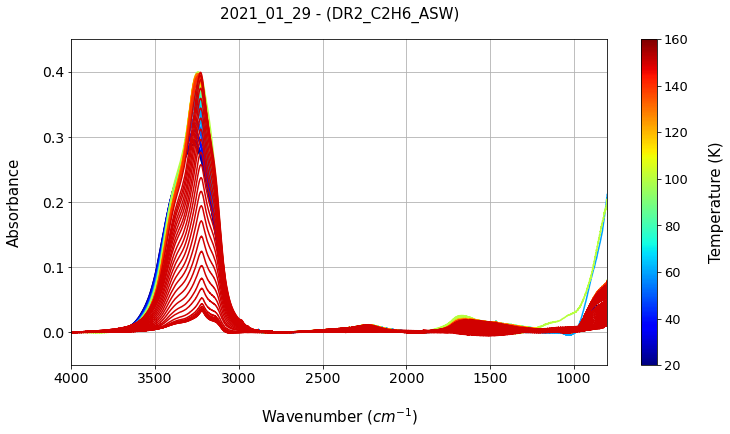

In [14]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(12,6))

for keys, values in Tdictionary.items():
    
    temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=20, vmax=160)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(All_data_BC.Wavenumber, All_data_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(temp)))
    
    
    

plt.title('{} - (DR2_{})'.format(date,spl), fontsize=15, pad=20)
plt.axis([4000,800,-0.05,0.45])
plt.xlabel('Wavenumber ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Temperature (K)', labelpad=20 ,size=15)

#plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_Full-range.png".format(XP,date,date))



### Sub-range 1

91


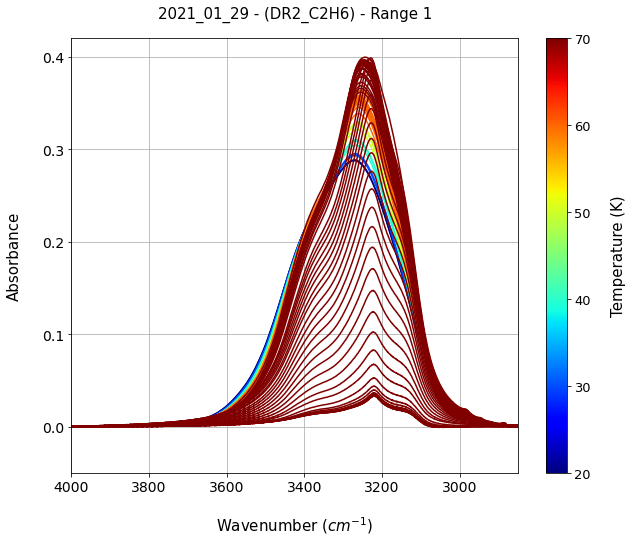

In [20]:
nscan = len(list(All_RAW_df.columns.values.tolist()))

print(nscan)


fig= plt.figure(figsize=(10,8))

for keys, values in Tdictionary.items():
    
    temp = int(keys)
    scan = json.loads(values)

    normalize = mcolors.Normalize(vmin=20, vmax=70)
    colormap = cm.jet

    for i in scan:
    
        plt.plot(All_data_BC.Wavenumber, All_data_BC['{}_{}_{}'.format(spl, date, i)], color=colormap(normalize(temp)))
    
    
    

plt.title('{0} - (DR2_C2H6) - Range 1'.format(date), fontsize=15, pad=20)
plt.axis([4000,2850,-0.05,0.42])
plt.xlabel('Wavenumber ($cm^{-1}$)', labelpad=20).set_fontsize(15)
plt.ylabel('Absorbance', labelpad=20).set_fontsize(15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
#ax = fig.gca()
plt.grid()
#plt.legend()

scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(nscan)
cbar = plt.colorbar(scalarmappaple)
cbar.ax.tick_params(labelsize=13)
cbar.set_label('Temperature (K)', labelpad=20 ,size=15)

#plt.savefig("..\..\DATA\DATA-Processing\PAC\{}/Samples/{}/Plots/DR/DR2_{}_sub-range_1.png".format(XP,date,date))


plt.show()